In [1]:
import os
import sys
import pandas as pd
import datetime

import pathlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import importlib


from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import callbacks  

# project specific
sys.path.append('../src')
from utils import data_handler
from utils.models import vae



import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go



%load_ext tensorboard
!rm -rf ../workfiles/logs/

In [2]:
%load_ext tensorboard
!rm -rf ../workfiles/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Generate dataset

In [3]:
importlib.reload(data_handler) # to allow modification of the script without restarting the whole session

x_train, filenames, n_genes, gene_names = data_handler.generate_dataset(
    feature_selection_threshold = 0, 
    retain_phases=None, 
    normalization = False,
    as_time_series = False,
    log1p=True,
    MT_removal = True)


not applying any filtering over phases
retaining all patient who have at least passed the Base Line Visit...
loading samples...
loaded 4445 samples
retriving symbols for genes
removing 298 mithocondrial genes from the dataset
selecting genes based on median absolute deviation threshold:  0 ...
number of genes selected :  24414
number of seq in the dataset : 4445
keeping sample as is, no conversion to time series


### Generate model

In [16]:
importlib.reload(vae) # to allow modification of the script without restarting the whole session
latent_dim = 32

vae_model = vae.generate_model(n_genes, latent_dim)
vae_model.compile(optimizer=keras.optimizers.Adam(), loss = keras.losses.mean_squared_error)

#### Train Model

In [17]:
checkpoint_filepath = '../workfiles/simple_autoencoer_model/checkpoint'
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)


reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=15, min_lr=0.00001)

early_stopping_callback = callbacks.EarlyStopping(monitor='loss', patience=30)


log_dir = "../workfiles/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cb = [model_checkpoint_callback, reduce_lr, early_stopping_callback, tensorboard_callback]

In [18]:
hist = vae_model.fit(x_train, epochs = 200, callbacks = cb) 

Epoch 1/200


70/70 [==============================] - 39s 539ms/step - loss: 2.2000 - reconstruction_loss: 0.9498 - kl_loss: 0.0060 - lr: 0.0010
Epoch 2/200
70/70 [==============================] - 31s 437ms/step - loss: 0.3302 - reconstruction_loss: 0.3180 - kl_loss: 9.9042e-05 - lr: 0.0010
Epoch 3/200
70/70 [==============================] - 30s 433ms/step - loss: 0.2949 - reconstruction_loss: 0.2833 - kl_loss: 6.0096e-05 - lr: 0.0010
Epoch 4/200
70/70 [==============================] - 33s 467ms/step - loss: 0.2656 - reconstruction_loss: 0.2597 - kl_loss: 4.0234e-05 - lr: 0.0010
Epoch 5/200
70/70 [==============================] - 37s 529ms/step - loss: 0.2405 - reconstruction_loss: 0.2346 - kl_loss: 2.0802e-05 - lr: 0.0010
Epoch 6/200
70/70 [==============================] - 31s 436ms/step - loss: 0.2273 - reconstruction_loss: 0.2247 - kl_loss: 1.3985e-05 - lr: 0.0010
Epoch 7/200
70/70 [==============================] - 30s 433ms/step - loss: 0.2176 - reconstruction_loss: 0.2145 - kl_loss: 6.45

#### Monitoring training results

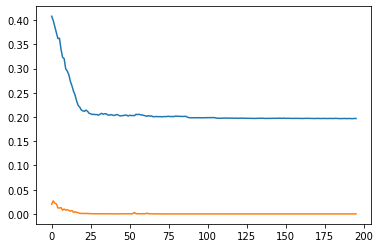

In [38]:
plt.plot(hist.history['reconstruction_loss'][4:])
plt.plot(hist.history['kl_loss'][4:])

In [39]:
e = iter(x_train).next()
_,__,z = vae_model.encoder(e)
decoded = vae_model.decoder(z)

In [40]:
e_ = e[0].reshape(1, -1) 
z_ = z[0].reshape(1, -1) 
decoded_ = decoded[0].reshape(1, -1) 



# Create subplot grid with vertical stacking
fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=False, vertical_spacing=0.1)

# Add the original image as a heatmap-like plot
heatmap_trace1 = go.Heatmap(z=e_, colorscale='viridis')
fig.add_trace(heatmap_trace1, row=1, col=1)

# Add the latent representation as a heatmap-like plot
heatmap_trace2 = go.Heatmap(z=z_, colorscale='viridis')
fig.add_trace(heatmap_trace2, row=2, col=1)

# Add the decoded image as a heatmap-like plot
heatmap_trace3 = go.Heatmap(z=decoded_, colorscale='viridis')
fig.add_trace(heatmap_trace3, row=3, col=1)

# Update layout
fig.update_layout(title='Stacked Graph of Image and Latent Space', showlegend=False)

# Update x-axis labels
#fig.update_xaxes(title_text='genes (normalized)', row=1, col=1)
#fig.update_xaxes(title_text='latent representation', row=2, col=1)
#fig.update_xaxes(title_text='genes (normalized)', row=3, col=1)

# Update y-axis labels
#fig.update_yaxes(title_text='timestamps', row=1, col=1)
#fig.update_yaxes(title_text='latent representation', row=2, col=1)
#fig.update_yaxes(title_text='timestamps', row=3, col=1)

fig.show()

In [41]:
vae_model.encoder.save('../workfiles/vae_model')

INFO:tensorflow:Assets written to: ../workfiles/vae_model/assets


INFO:tensorflow:Assets written to: ../workfiles/vae_model/assets


### encoding the whole dataset

In [42]:
_, __, compressed_dataframe = vae_model.encoder.predict(x_train)


23/23 [==============================] - 0s 7ms/step


In [43]:
df = pd.DataFrame(compressed_dataframe)
df["name"] = filenames

In [44]:
df.to_csv("../workfiles/processed_data_vae.csv", index=False)


# A bit of post training viz

In [45]:
import seaborn as sns

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



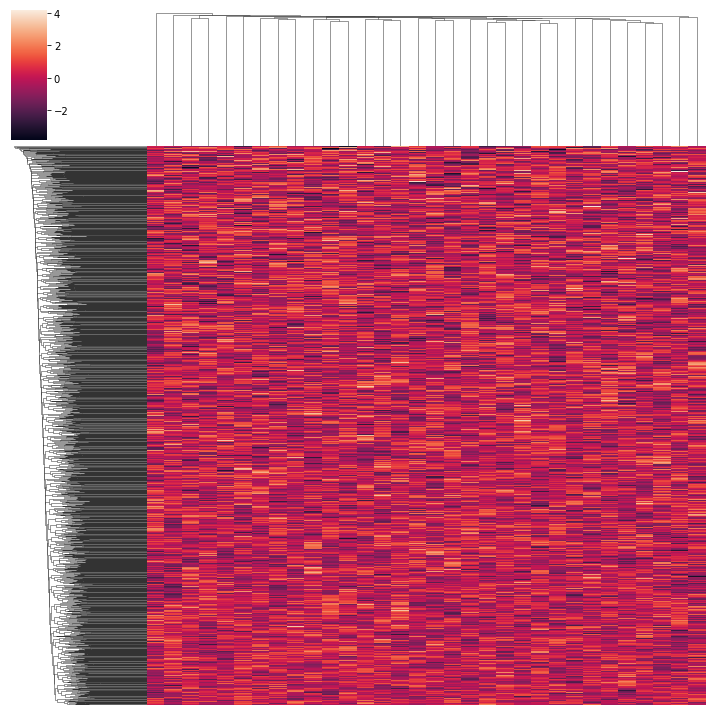

In [48]:
cluster_plot = sns.clustermap(compressed_dataframe,yticklabels=False,xticklabels=False)
cluster_plot
# this plot shows basically random noise, which is what you shoud expect from variational autoencoders

In [49]:
# let's reconstruct the dataset 
decoded = vae_model.decoder.predict(compressed_dataframe)

46/46 [==============================] - 0s 3ms/step


/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



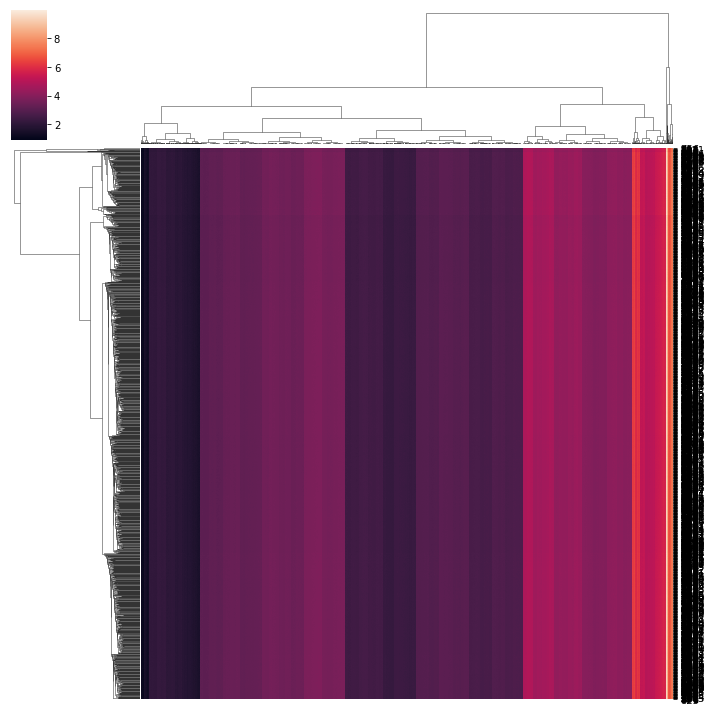

In [51]:
cluster_plot = sns.clustermap(decoded,yticklabels=True,xticklabels=False)
cluster_plot

In [54]:
# get everything out of TensorFlow back to numpy/pandas
data = np.concatenate(list(x_train.as_numpy_iterator()), axis=0)
data = pd.DataFrame(data)
data.columns = gene_names
data.index = filenames

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/opt/homebrew/anaconda3/envs/thesis/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



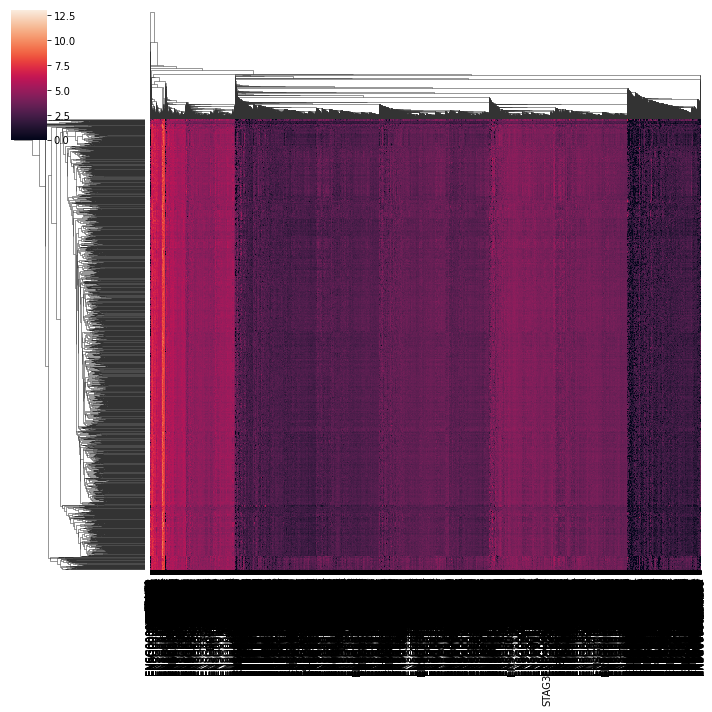

In [56]:
cluster_plot = sns.clustermap(data,yticklabels=False,xticklabels=True)
cluster_plot